# Geotechnical Data Organiser - Example Usage

### Get Parameters (reference from Alan)


In [1]:
import json

from DataOrganizer import CouchbaseSelector

db = CouchbaseSelector('localhost','nem-data')

parameter = 'E'
fields = ['laboratory', 'value', 'value_unit']
selector = {'data_source': 'laboratory'}

E=[]   #E = {}
for rec in db.get_parameter(parameter, fields, selector):
    print json.dumps(rec)
    E.append(rec)   #E.update(rec)


{"laboratory": "Khon Kaen University", "value_unit": "MPa", "value": 24630}
{"laboratory": "Khon Kaen University", "value_unit": "MPa", "value": 18100}


In [75]:
type(E[0])

dict

In [76]:
E[0]

{u'laboratory': u'Khon Kaen University',
 u'value': 24630,
 u'value_unit': u'MPa'}

In [77]:
E[0]['value']

24630

In [79]:
#values=[]
#for rec in recs:
#  values.append(rec['value'])
#print values

# Example with hard-coded data, note value_units: MPa vs. KPa

recs = [{"value_unit": "KPa", "value": 24630}, 
        {"value_unit": "MPa", "value": 18.100}, 
        # {"value_unit": "m/sec", "value": 0} 
       ]

values = []
for rec in recs:
    print rec
    if rec.get('value_unit') == 'KPa':  # dict.get(key) doesn't throw error when key not found, vs. dict[key]
        values.append(rec['value'])
    elif rec['value_unit'] == 'MPa': # MPa
        values.append(rec['value']*1000)
    else:
        raise ValueError("Invalid units: "+str(rec['value_unit']))
        
print values

{'value': 24630, 'value_unit': 'KPa'}
{'value': 18.1, 'value_unit': 'MPa'}
[24630, 18100.0]


### TESTING JK

In [80]:
# define class ElasticityModule for handling data associated with elastic parameters
# reference data are E,nu (e.g. these are the data stored in the database)
#   Is there a better way of doing this?                                                                  ToDo JK
class ElasticityModule(list):
    """conversion between elasticity parameters"""
    def toG(self):  #method for converting E-modulus to G-modulus
        # print(self)
        G=[i /(2*(1+nu)) for i in self]
        return G
    # to be continues with methods for other elasticity parameters
    
# instantiate E as an instance of class ElasticityModule 
# lower case is preferred Python style; for me upper case variable are easier to read in calculations
#   a Data Organiseer style decision is required                                                        ToDo JK
E = ElasticityModule()

#default vale for nu (typical value for rock), may be overridden by database query
nu=0.20 

# initialize selected attributes for E
E.lithology=[]  # attributes to E are tuples (immutable - fits purpose)
E.laboratory_test_code=[]
E.sample_code=[]

# Notes:
#   Why isn't subclassing a list a good idea? 
#   - some Stack Overflow commenters suggests not a good idea, but may refer to versions before python 2.3
#   Is just using funcions a better way for doing this?
#   - I would however like to limit the use of E.toG to selected parameters (e.g. E)
#   - advice seems to be: functions for general use, methods for use by selected objects

In [81]:
# Example of how Data Organizer is used in practice
# to 1) check data and 2) prepare data array for calculation procedures     

import json

lithology=[]  
laboratory_test_code=[]
sample_code=[]
nem_data=[]

# open Data Organizer
from DataOrganizer import CouchbaseSelector
db = CouchbaseSelector('localhost','nem-data')

# query Data Organizer for data
parameter = 'E'
fields = ['lithology','laboratory', 'laboratory_test_code', 'sample_code', 'value', 'value_unit']
selector = {'data_source': 'laboratory'}
#selector = {'data_source': 'laboratory', 'lithology': 'Sandstone'}

# write 'values' to E   -testing JK
# write selected attributes to lists
for rec in db.get_parameter(parameter, fields, selector):
    print rec 
    # write rec to nem_data   -testing JK
    nem_data.append(rec)
    # need to provide a better 'table' of returned data to encourage data checking                 ToDo JK
    # 'table' should also provide count information (see below "reference from Alan")
    # what to do about "u" preceeding string                                                       ToDo JK
    try:
        E.append(rec['value'])
    except:
        print "check value data for E=", rec['value']
    try:
        lithology.append(rec['lithology'])
    except:
        print "check lithology data for E=", rec['value']
    try:
        laboratory_test_code.append(rec['laboratory_test_code'])
    except:
        print "check laboratory_test_code data for E=", rec['value']
    try:
        sample_code.append(rec['sample_code'])
    except:
        print "check sample_code data for E=", rec['value']
    # there must be a more elegant way of checking that data exists                               Todo JK  
    #   how to mark missing data as 'NaN' ?

# write selected fields of E parameter to E
E.lithology=lithology
E.laboratory_test_code=laboratory_test_code
E.sample_code=sample_code
#print E.lithology

# calculate G based on E values
G=E.toG()
print G

{u'laboratory_test_code': u'11', u'lithology': u'Diorite', u'value': 24630, u'sample_code': u'NE02', u'laboratory': u'Khon Kaen University', u'value_unit': u'MPa'}
{u'laboratory': u'Khon Kaen University', u'value_unit': u'MPa', u'value': 18100, u'lithology': u'Diorite', u'sample_code': u'NE02'}
check laboratory_test_code data for E= 18100
[10262.5, 7541.666666666667]


In [82]:
# read nem_data into pandas data frame for reporting   -testing JK
#print(nem_data)
import pandas as pd
nem_data_df = pd.DataFrame(data=nem_data)#nem_data_df = nem_data_df.fillna('NaN').T
#print(df)

In [83]:
# display nem_data_df as html using pandas df.to_html()
from IPython.core.display import display, HTML
display(HTML('<h4>NEM data</h4>'))
display(HTML(nem_data_df.to_html()))

,laboratory,laboratory_test_code,lithology,sample_code,value,value_unit
0,Khon Kaen University,11,Diorite,NE02,24630,MPa
1,Khon Kaen University,NaN,Diorite,NE02,18100,MPa


In [84]:
# E data to be used for scatterplot by sample_code, for histograms by lithology and for 'Deere plot' by sample_cde
#   need to also query sigma_c data from Data Oranizer
print E
print E.toG()
print E.lithology
print E.sample_code

[24630, 18100]
[10262.5, 7541.666666666667]
[u'Diorite', u'Diorite']
[u'NE02', u'NE02']


In [85]:
# test data for scatterplot with cut and paste data directly from laboratory spreadsheet 
# until .csv is uploaded to couchdb
#   data was sorted by 1) borehole and 2) sample_depth in spreadsheet prior to copying
#   so list data is ordered as above
data_e=(12800,18100,29700,18300,5650,5769.2,2574.3,8076.9,14600,16800,13300,30500,22100,
        3891.9,6375,10769.2,8139.5,21500,15700,30600,19300,14800,19200)
data_sigma_c=(84.78,153.5,211.63,167.37,122.42,60.26,9.71,84.46,104.25,158.28,134.33,153.02,193.46,
              28.58,41.28,115.72,73.36,193.52,204.34,268.27,117.59,183.13,193.52)
data_lithology=('Diorite','Diorite','Pegmatite','Diorite','Pegmatite','Granodiorite','Granodiorite','Granodiorite',
                'Sandstone','Sandstone','Sandstone','Sandstone','Sandstone','Sericite','Sericite','Sericite',
                'Sericite','Granodiorite','Granodiorite','Granodiorite','Granodiorite','Diorite','Diorite')
# check number or records same for all data lists
print(len(data_e))
print(len(data_sigma_c))   
print(len(data_lithology))

# assign colors to lithologies for use in scatterplot
colors=[]
for i in range(0,len(data_lithology)):
    if data_lithology[i]=='Sandstone':
        colors.append('orange')
    elif data_lithology[i]=='Diorite':
        colors.append('black')
    elif data_lithology[i]=='Pegmatite':
        colors.append('blue')
    elif data_lithology[i]=='Granodiorite':
        colors.append('gray')
    elif data_lithology[i]=='Sericite':
        colors.append('green')
    else:
        colors.append('red')
#print(colors)

23
23
23


In [86]:
# initial test data for historgrams
data=(15850, 52930, 21560, 14460, 21290, 20800, 19170, 30450, 44310, 71420, 21790, 20940, 19080, 
      29530, 27420, 8475, 4799.2, 11968.7, 14813.1, 11893.5, 7963.4, 9053.3, 12800, 29700, 18300, 
      5650, 14600, 16800, 13300, 30500, 22100, 30600, 15700, 19300, 14800,21500, 19200, 5769.2, 2574.3, 
      8076.9, 10769.2, 8139.5, 3891.9, 6375)
for rec in data:
    E.append(rec)
#print E
len(E)

46

In [87]:
# crude testing preparing data for 'parameter' E plotting histogram
# simply cutting from the laboratory spreadsheet and pasting here 
# (with somerearrangement because existing two data points were also used)
lithology=('Diorite','Diorite','Diorite','Pegmatite','Diorite','Pegmatite','Sandstone','Sandstone','Sandstone',
           'Sandstone','Sandstone','Granodiorite','Granodiorite','Granodiorite','Diorite','Granodiorite','Diorite',
           'Granodiorite','Granodiorite','Granodiorite','Sericite','Sericite','Sericite','Sericite','Diorite',
           'Pegmatite','Diorite','Pegmatite','Sandstone','Sandstone','Sandstone','Sandstone','Sandstone',
           'Granodiorite','Granodiorite','Granodiorite','Diorite','Granodiorite','Diorite','Granodiorite',
           'Granodiorite','Granodiorite','Sericite','Sericite','Sericite','Sericite')
print("length=", len(lithology))

# select E values where 'lithology' is Sandstone
sandstone_i=[]
E_i=[]
i=1
for i in range(0,len(lithology)):
    if lithology[i]=='Sandstone':
        sandstone_i.append(i)
        #print i, lithology[i]
        E_i.append(E[i])
print(sandstone_i)
print(E_i)

('length=', 46)
[6, 7, 8, 9, 10, 28, 29, 30, 31, 32]
[21290, 20800, 19170, 30450, 44310, 14600, 16800, 13300, 30500, 22100]


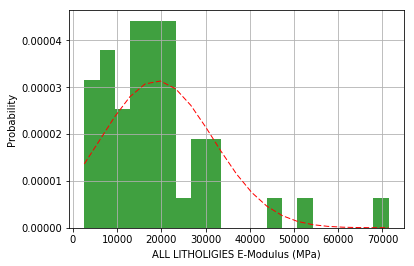

18981.3521739
12709.1651504


46

In [88]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm

# input: E containing 'values' of 'parameter' E

# plot histogram of E values for all rock lithologies
# plt.hist(values, number of bins, additional named parameters)
hist,bin_edges,patches = plt.hist(E, 20, normed=1, facecolor='green', alpha=0.75)
# just guessing at distribution
#mu, sigma = 15000, 10000
#y = mlab.normpdf( bin_edges, mu, sigma)
#l = plt.plot(bin_edges, y, 'b--', linewidth=1)

# calculating distribution of E values using scipy
param = norm.fit(E) 
# now, param[0] and param[1] are the mean and 
# the standard deviation of the fitted distribution
y = mlab.normpdf( bin_edges, param[0], param[1])
ll = plt.plot(bin_edges, y, 'r--', linewidth=1)

# plot axis labels and grid
plt.ylabel('Probability')
plt.xlabel('ALL LITHOLIGIES E-Modulus (MPa)')
plt.grid(True)
plt.show()

print(param[0])  # mean
print(param[1])  # standard deviation
len(E) # one more check

# "added value": results show one of the problems facing an 'uneducate' view of getoechnical data statistics:
#   lower tail goes negative, which is pysically impossible! 
#   e--> we need a skew distribution --> can be significant difference in outcomes

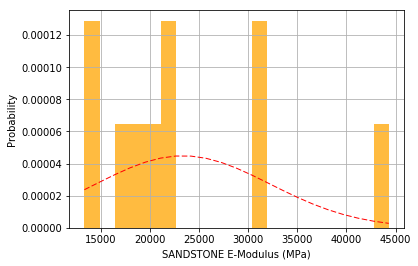

23332.0
8894.37665045


In [89]:
# input: E containing 'values' of 'parameter' E

# plot histogram for E values of Sandstones
n, bins, patches = plt.hist(E_i, 20, normed=1, facecolor='orange', alpha=0.75)

# calculating distribution with data using scipy
param = norm.fit(E_i) 
# now, param[0] and param[1] are the mean and 
# the standard deviation of the fitted distribution
y = mlab.normpdf( bins, param[0], param[1])
ll = plt.plot(bins, y, 'r--', linewidth=1)

plt.ylabel('Probability')
plt.xlabel('SANDSTONE E-Modulus (MPa)')
plt.grid(True)
plt.show()
print(param[0])
print(param[1])
#len(E_i)
# added value: results show one of the problems facing an 'uneducate' view of getoechnical data statistics:
#   lower tail goes negative, which is pysically impossible! 
#   e--> we need a skew distribution --> can be significant difference in outcomes

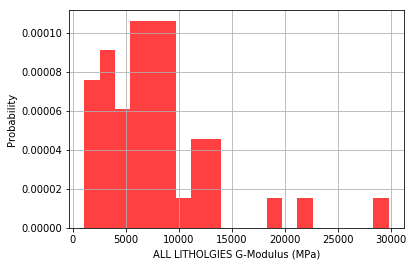

In [90]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# input: E containing 'values' of 'parameter' E 
#        Method for caclulating G from E

# plot histogram for G values for all rock lithologies
n, bins, patches = plt.hist(E.toG(), 20, normed=1, facecolor='red', alpha=0.75)

plt.ylabel('Probability')
plt.xlabel('ALL LITHOLGIES G-Modulus (MPa)')
plt.grid(True)

plt.show()

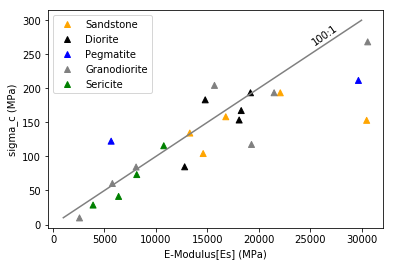

In [93]:
from matplotlib.lines import Line2D

# input: data_e, data_sigma_c containing 'values' of 'parameter' E and sigma_c
#        colors containg list of colors for lithologies in records (colors previously assigned lithologies)

# scatterplot of E against sigma_c for all rock lithologies
rock_plot=plt.scatter([data_e],[data_sigma_c],color=colors,marker='^')

# legend
sym1 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, color="orange")
sym2 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, color="black")
sym3 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, color="blue")
sym4 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, color="gray")
sym5 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, color="green")
plt.legend((sym1,sym2,sym3,sym4,sym5),("Sandstone","Diorite","Pegmatite","Granodiorite","Sericite"),
           numpoints=1,loc="best")

# axis labels
plt.ylabel('sigma_c (MPa)')
plt.xlabel('E-Modulus[Es] (MPa)')
plt.plot((1000,10000,20000,30000),(10,100,200,300), color="gray")

# a reference trend line
plt.annotate("100:1",xy=(25000,250),xytext=(25000,285),rotation=35)

plt.show()

## Get count and parameter count (reference from Alan)

In [67]:
import json

from DataOrganizer import CouchbaseSelector

db = CouchbaseSelector('localhost','nem-data')  # 'nem-data' is geotechnical db

parameter = 'sigma_c'
selector = {'type': 'parameter'}

count = db.get_count(selector)
print "count = "+str(count)

count = db.get_parameter_count(parameter)
print "parameter count = "+str(count)


count = 4
parameter count = 2


In [68]:
class ElasticityModule(list):
    """conversion between elasticity parameters"""
    def toG(self):  #method for converting E-modulus to G-modulus
        print(self)
        G=[i /1.4 for i in self]
        return G
data = (1,2,3,4)  #list comes from e.g. Data Organiser
e = ElasticityModule(data) 
print e
g = e.toG()
print g
# Why isn't subclassing a list a good idea (Stack Overflow suggests not a good idea)?
# Is just using funcions a better way for doing this?
#    - I would however like to limit the use of EtoG to certain objects (e.g. E)
#    - advice seems to be: functions for general use, methods for use by selected objects

[1, 2, 3, 4]
[1, 2, 3, 4]
[0.7142857142857143, 1.4285714285714286, 2.142857142857143, 2.857142857142857]


In [69]:
G=E.toG();
G

[10262.5,
 7541.666666666667,
 6604.166666666667,
 22054.166666666668,
 8983.333333333334,
 6025.0,
 8870.833333333334,
 8666.666666666668,
 7987.5,
 12687.5,
 18462.5,
 29758.333333333336,
 9079.166666666668,
 8725.0,
 7950.0,
 12304.166666666668,
 11425.0,
 3531.25,
 1999.6666666666667,
 4986.958333333334,
 6172.125,
 4955.625,
 3318.0833333333335,
 3772.208333333333,
 5333.333333333334,
 12375.0,
 7625.0,
 2354.166666666667,
 6083.333333333334,
 7000.0,
 5541.666666666667,
 12708.333333333334,
 9208.333333333334,
 12750.0,
 6541.666666666667,
 8041.666666666667,
 6166.666666666667,
 8958.333333333334,
 8000.0,
 2403.8333333333335,
 1072.6250000000002,
 3365.375,
 4487.166666666667,
 3391.4583333333335,
 1621.625,
 2656.25]

In [70]:
import pandas
from scipy.stats import norm

In [71]:
type(E)

__main__.ElasticityModule

In [72]:
def myfunc():
    d = {'Retry': ['30', '12', '12'],
         'Station MAC': ['aabbccddeea', 'ffgghhiijj', 'kkllmmnnoo'],
         'Download': ['70.', '99', '90']}
    colnames = ['Retry', 'Station MAC', 'Download']
    rows = zip(*[d[c] for c in colnames])
    return dict(rows=rows, colnames=colnames)

In [73]:
myfunc()

{'colnames': ['Retry', 'Station MAC', 'Download'],
 'rows': [('30', 'aabbccddeea', '70.'),
  ('12', 'ffgghhiijj', '99'),
  ('12', 'kkllmmnnoo', '90')]}